### Process:
1. Ensure that we are trading every hour
2. Get live data (3 Data points to account for the data preparation)
3. Append it to csv, ensuring the limit of data points in the csv file (the limit == the train_size for the optimization process)
4. Load the data from the csv file
5. optimize if time to optimize (use optimize_counter)
6. rebalance if time to rebalance (use rebalance_counter)
7. Run the strategy on the dataset
8. On the last time index (the last candle), get the universe (level 2 index) and actual allocation for each coin\
=> Make sure that we have applied self.live = True when initiating the strategy (to not shift the position values)\
(a) If coin not in universe -> Put their allocation\
(b) If actual allocation != shifted allocation, change the allocation of the coin\
--> Changing the allocation of a coin, is by determining the amount in currency = (amount_USD / close_price) to sell or to buy, then placing that order

---

# Strategy Optimization and Portfolio Management

---

## At Boot

1. Get all symbols.
2. Fetch `market_data` (up-to-date data) and trim it to `train_size + test_size` (assuming a constant `step_size` equal to `train_size`).
3. Format symbols to match the exchange (e.g., Kraken).
4. Use `halal_symbols` to get halal data.
5. Save `market_data` to `market_data.csv`.
6. Initialize the `strategy_instances` map (add all strategies into a dictionary).

---

## **For Strategy Optimization**

### When Optimizing

1. Run strategy optimization (not walk-forward optimization) for each strategy to determine `best_params`.
2. Store `best_params` for each strategy in a dictionary for later use.
3. Run each strategy with its `best_params`.

---

## **For Portfolio Management**

### When Optimizing

1. Perform the walk-forward optimization (WFO) process for each strategy using all `market_data` to get results for each strategy.
2. Extract `strategy_returns` from the WFO results for each strategy.
3. Set the `max_allocation` parameter to 1.
4. Run portfolio management on `strategy_returns` to create a new map of selected strategies (on each optimization).
5. Store the `selected_strategy_map` for later use.

---

## **For Portfolio Optimization**

### When Rebalancing

1. Run the WFO process for each selected strategy using all `market_data` to obtain results.
2. Perform portfolio optimization on `strategy_returns` to calculate weights:
   - Use `max_allocation` based on `current_total_balance * weight`.

---

## **For Portfolio Risk Management**

### At Each Time We Loop

1. Run each strategy with its `best_params` on `market_data.csv`:
   - Set `max_allocation = max_allocation / max_positions * current_total_balance * according_weight`.
2. Obtain `strategy_returns` and their weights.
3. Run `calculate_returns()` from portfolio optimization to output `weighted_returns`.
4. Calculate cumulative return (`current_portfolio_returns`) from `weighted_returns`.
5. Perform portfolio risk management on `current_portfolio_returns`:
   - If `True` in the last row of `portfolio_rm`:
     - Check if holding any coins:
       - Liquidate all coins in the portfolio balance.
     - Continue.
   - If `False`, do nothing.

---

## **Taking Positions**

### At Each Time We Loop

1. Update the strategy map with the `max_allocation` for each strategy instance.
2. Fetch the `current_total_balance` of the portfolio from the exchange.
3. Get the latest data using `halal_symbols` and append to `market_data.csv`.
4. Ensure `market_data` length equals `train_size + test_size`.
5. Run each strategy with `best_params` on `market_data.csv`:
   - Update `max_allocation = max_allocation / max_positions * current_total_balance * according_weight`.
6. Obtain the DataFrame for each strategy.
7. Concatenate all strategies' data (`index['coin']`, `current_allocation`).
8. Calculate allocation per coin (as a dictionary mapping allocations to names).
9. Identify `current_universe` (using the last row of `df_strategies`).
10. Determine `current_allocation_coin_currency` for each coin:
    - `df_strategies['current_allocation'] / df_strategies['close']`.
11. Identify `current_held_coin` from the portfolio.
12. Liquidate all coins not in the `current_universe`.
13. For each coin:
    - Fetch its current balance and actual allocation from `df_strategies`.
    - Calculate `position_to_add`.
    - If `position_to_add > 0`, execute a buy signal; otherwise, execute a sell signal.

---

## **Combining Processes**

Processes occurring simultaneously can be combined under a single method to avoid redundancy.

---

## **Initialization Variables**

- `strat_1_instance = ...`
- `strat_2_instance = ...`
- `counter = 0`
- `cash_df = ...`
- `strategy_map = {}`
- `best_params = None`
- `best_weights = None`
- `exchange = ...`
- `halal_symbols = ...`
- `symbols_to_liquidate = None`
- `selected_strategy = None`
- `drawdown_threshold = -0.15`
- `train_size = 440`
- `test_size = 200`
- `step_size = 200`
- `low_corr_thresh = 1`
- `strategy_data_filename = 'strategy_data.csv'`
- `market_data_filename = 'market_data.csv'`
- `max_rows_market_data = market_data_size = 2000`
- `timeframe = '1h'`
- `strategy_optimization_frequency = step_size`
- `portfolio_optimization_frequency = 300`
- `portfolio_management_frequency = 4380` (Every 6 months)

---

## **Execution**

### Before the Main Loop

1. Load `market_data.csv`.

### Main Loop

At the beginning of each hour:
1. Perform optimization: `perform_optimization()`.
2. Perform portfolio optimization: `perform_portfolio_optimization()`.
3. Perform portfolio management: `perform_portfolio_management()`.
4. Perform portfolio risk management: `perform_portfolio_rm()`:
   - Continue if it outputs `True` (indicating a drawdown).
5. Execute strategies: `run_strategy()`.


In [1]:
def symbols_in_current_balance(exchange):
    # Fetch account balance
    try:
        balance = exchange.fetch_balance()
        
        # Extract symbols with non-zero balance
        symbols = [currency + 'USDT' for currency, info in balance['total'].items() if info > 0]
        
        print("Symbols in your current balance:", symbols)
    except ccxt.BaseError as e:
        print(f"An error occurred: {e}")

In [2]:
def buy(to_add, coin, exchange):
    try:
        order = exchange.create_market_buy_order(coin, to_add)
        print(f"Buy order placed: {order}")
    except Exception as e:
        print(f"Error: {e}")

In [3]:
def sell(to_sell, coin, exchange):
    try:
        order = exchange.create_market_sell_order(coin, to_sell)
        print(f"Sell order placed: {order}")
    except Exception as e:
        print(f"Error: {e}")

In [4]:
def liquidate(symbols, exchange):
    try:
        # Step 1: Get your balances
        balance = exchange.fetch_balance()

        # Step 2: Loop through all assets in your balance and sell them
        for coin, coin_balance in balance['free'].items():
            if coin in symbols:
                if coin_balance > 0:  # Only sell if you have a non-zero balance
                    print(f"Selling {coin_balance} {coin}...")

                    # Determine the symbol for the sell order (e.g., BTC/USD, ETH/USDT)
                    symbol = f"{coin}/USD"  # Replace USD with your preferred quote currency
                    order = exchange.create_market_sell_order(symbol, coin_balance)
                    print(f"Sell order placed: {order}")
                else:
                    print(f"No {coin} to sell.")

        print("All possible assets have been liquidated.")

    except Exception as e:
        print(f"Error: {e}")

In [5]:
import ccxt
import pandas as pd
import numpy as np
import os
import time
from unsync import unsync
import datetime as dt
import sys
from concurrent.futures import ThreadPoolExecutor
import re
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [6]:
# Ensure the directories are in the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Data_Management'))) 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Portfolio_Optimization'))) 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Strategies', 'Trend_Following')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Strategies', 'Mean_Reversion')))

# Import the modules
from data import Data, get_halal_symbols
from fetch_symbols import get_symbols
from sprtrnd_breakout import Sprtrnd_Breakout
from last_days_low import Last_Days_Low
from portfolio_management import Portfolio_Management
from portfolio_optimization import Portfolio_Optimization
from portfolio_risk_management import Portfolio_RM


### At boot

In [7]:
#Connect to exchange
api_key = 'yqPWrtVuElaIExKmIp/E/upTOz/to1x7tC3JoFUxoSTKWCOorT6ifF/B'
api_secret = 'L8h5vYoAu/jpQiBROA9yKN41FGwZAGGVF3nfrC5f5EiaoF7VksruPVdD7x1VOwnyyNCMdrGnT8lP4xHTiBrYMQ=='

exchange = ccxt.kraken({
    'apiKey': api_key,
    'secret': api_secret
})

In [8]:
all_symbols = get_symbols()

In [9]:
train_size = 440
test_size = 200
step_size = 200

In [10]:
start_time = (dt.datetime.now() - dt.timedelta(hours=train_size + test_size + 200)).date()
end_time = dt.datetime.now().date()
timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
interval = timeframes[index]
symbols = ['BTCUSD', 'ETHUSD']
data_instance = Data(symbols, interval, start_time, end_time, exchange = 'kraken', get_data = False)

In [80]:
data = data_instance.get_data()

In [81]:
last_date_data = data.index.get_level_values(0).unique()[-1].tz_localize('UTC')

In [89]:
if dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) != last_date_data:
    time_difference = dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) - last_date_data
    hours_difference = time_difference.total_seconds() / 3600 # Get the number of hours
    missing_data = fetch_latest_data(all_symbols, interval, limit = int(hours_difference) + 1).result()
    complete_data = pd.concat([data, missing_data])

In [92]:
complete_data.index = complete_data.index.set_levels(pd.to_datetime(complete_data.index.levels[0]), level=0)

In [94]:
complete_data.to_csv('market_data.csv')

Putting all together

In [10]:
def upload_complete_market_data(halal_symbols, data_size = 2200):
    start_time = (dt.datetime.now() - dt.timedelta(hours= data_size)).date()
    end_time = dt.datetime.now().date()
    timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
    index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
    interval = timeframes[index]
    data_instance = Data(halal_symbols, interval, start_time, end_time, exchange = 'kraken')
    data = data_instance.df
    last_date_data = data.index.get_level_values(0).unique()[-1].tz_localize('UTC')
    
    if dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) != last_date_data:
        time_difference = dt.datetime.now(dt.UTC).replace(minute=0, second=0, microsecond=0) - last_date_data
        hours_difference = time_difference.total_seconds() / 3600 # Get the number of hours
        missing_data = fetch_latest_data(halal_symbols, interval, limit = int(hours_difference) + 1).result()
        complete_data = pd.concat([data, missing_data])
        
    complete_data.index = complete_data.index.set_levels(pd.to_datetime(complete_data.index.levels[0]), level=0)
    complete_data.to_csv('market_data.csv')
    print('Market data updated successfully')

In [22]:
upload_complete_market_data(symbols, data_size = (train_size + test_size) * 4)

Market data updated successfully


### At each time we loop

In [16]:
#Helper function
def get_last_row(data):
    """Get the last date in the dataset."""
    last_date = data.index.get_level_values("date").max()
    last_date_data = data.loc[last_date]
    return last_date_data

In [17]:
def get_portfolio_value(exchange):
    try:
        # Fetch account balances
        balances = exchange.fetch_balance()

        # Fetch tickers to get the latest prices
        tickers = exchange.fetch_tickers()

        # Calculate portfolio value in USD (or another base currency)
        portfolio_value = 0.0

        for currency, balance in balances['total'].items():
            if balance > 0:
                if currency == "USD":
                    # Add USD cash directly to portfolio value
                    portfolio_value += balance
                else:
                    # Use the USD pair or the most liquid market
                    pair = f"{currency}/USD"
                    if pair in tickers:
                        price = tickers[pair]['last']
                        portfolio_value += balance * price
                    else:
                        # Handle currencies without USD pairs (e.g., trade to BTC, then USD)
                        btc_pair = f"{currency}/BTC"
                        if btc_pair in tickers:
                            btc_price = tickers[btc_pair]['last']
                            usd_price = tickers["BTC/USD"]['last']
                            portfolio_value += balance * btc_price * usd_price

        return round(portfolio_value, 2)

    except ccxt.BaseError as e:
        print(f"An error occurred: {str(e)}")
        return None


In [36]:
portfolio_value = get_portfolio_value(exchange)

In [37]:
portfolio_value

33.3

In [18]:
def format_symbols(symbols):
    """Converts the symbols to a format that the exchange understands."""
    if symbols[0].endswith('T'):
        symbols = [s[:-1] for s in symbols]
    formatted_symbols = [symbol.replace("USD", "/USD") for symbol in symbols]
    return formatted_symbols

def filter_halal_df(data):
    # Drop multiple coins
    halal_symbols = ['BTC/USD', 'ETH/USD', 'LTC/USD']
    data_filtered = data[data.index.get_level_values("coin").isin(halal_symbols)]
    return data_filtered

In [ ]:
halal_symbols = get_halal_symbols()

In [ ]:
formatted_halal_symbols = format_symbols(halal_symbols)

In [19]:
@unsync
def fetch_latest_data(symbols, timeframe, limit=2):
    """Fetch latest OHLCV data for multiple symbols and stack them into a single DataFrame."""
    
    formatted_symbols = format_symbols(symbols)
    
    def fetch_symbol_data(symbol):
        """Fetch data for a single symbol and return a DataFrame."""
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            df['coin'] = symbol
            return df
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            return pd.DataFrame()  # Return an empty DataFrame if fetching fails

    # Use ThreadPoolExecutor for parallel requests
    with ThreadPoolExecutor(max_workers=16) as executor:  # Adjust workers based on CPU
        results = list(executor.map(fetch_symbol_data, formatted_symbols))

    # Concatenate all DataFrames and set multi-level index
    data_frames = [df for df in results if not df.empty]
    if data_frames:
        stacked_df = pd.concat(data_frames)
        stacked_df.set_index('coin', append=True, inplace=True)
        stacked_df = stacked_df[~stacked_df.index.duplicated()]  # Remove duplicates
        df = data_instance.prepare_data(stacked_df.unstack())
        df.reset_index(level = 1, inplace = True)
        df['coin'] = df['coin'].str.replace('/USD', 'USDT', regex=False)
        df.set_index('coin', append = True, inplace = True)
        return df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no data

In [23]:
# Example usage
timeframe = '1h'
latest = fetch_latest_data(symbols, timeframe).result()

In [24]:
latest

close  creturns     high  log_return  \
date                coin                                               
2025-01-15 05:00:00 BTCUSDT  96885.50  0.997225  97175.1   -0.002779   
                    ETHUSDT   3224.24  0.999303   3226.5   -0.000698   

                                  low     open     price   returns     volume  \
date                coin                                                        
2025-01-15 05:00:00 BTCUSDT  96765.70  97155.1  96885.50 -0.002775  11.885451   
                    ETHUSDT   3216.51   3226.5   3224.24 -0.000697  60.258220   

                             volume_in_dollars  
date                coin                        
2025-01-15 05:00:00 BTCUSDT       1.151528e+06  
                    ETHUSDT       1.942870e+05

In [20]:
# Append new data to CSV and maintain max length (asynchronous)
@unsync
def append_to_csv_with_limit(data, filename, max_rows=2202):
    """_summary_

    Args:
        data (_type_): _description_
        filename (_type_): _description_
        max_rows (int, optional): _description_. Defaults to 2202. Should be account for the max number of rows needed for any of the processes
    """
    file_exists = os.path.isfile(filename)
    df = pd.DataFrame(data)
    
    if file_exists:
        existing_df = pd.read_csv(filename, index_col=['date', 'coin'], parse_dates=['date'])
        if existing_df.index.get_level_values(0).unique()[-1] == latest.index.get_level_values(0).unique()[-1]:
            return
        combined_df = pd.concat([existing_df, df])
        if len(combined_df) > max_rows:
            combined_df = combined_df.iloc[-max_rows:]  # Keep only the last max_rows rows
        combined_df.to_csv(filename)
    else:
        print('File does not exist')
        df.to_csv(filename, mode='w', header=True)


In [27]:
append_to_csv_with_limit(latest, 'market_data.csv', max_rows= (test_size + train_size) * 4).result()

In [21]:
#Getting the data from csv
def load_data_from_csv(filename, train_size = 2000, test_size = 2000):
    if os.path.isfile(filename):
        data = pd.read_csv(filename, index_col=['date', 'coin'], parse_dates=['date'])
        if len(data) >= train_size + test_size:
            return data
    else:
        return pd.DataFrame()

In [25]:
data = load_data_from_csv('market_data.csv')

In [26]:
data

close  creturns      high  log_return  \
date                coin                                                
2024-09-30 01:00:00 BTCUSDT  64769.99  0.989401  65544.00   -0.010656   
                    ETHUSDT   2615.17  0.987348   2655.80   -0.012732   
2024-09-30 02:00:00 BTCUSDT  64376.01  0.983383  64810.00   -0.006101   
                    ETHUSDT   2613.27  0.986631   2622.00   -0.000727   
2024-09-30 03:00:00 BTCUSDT  64553.68  0.986097  64580.34    0.002756   
...                               ...       ...       ...         ...   
2025-01-15 03:00:00 ETHUSDT   3236.99  1.004425   3236.99    0.007847   
2025-01-15 04:00:00 BTCUSDT  97155.10  1.006162  97600.00   -0.000461   
                    ETHUSDT   3226.49  1.001167   3248.37   -0.003249   
2025-01-15 05:00:00 BTCUSDT  96885.50  1.003370  97175.10   -0.002779   
                    ETHUSDT   3224.24  1.000469   3226.50   -0.000698   

                                  low      open     price   returns  \
date                coin                                              
2024-09-30 01:00:00 BTCUSDT  64699.98  65463.86  64769.99 -0.010599   
                    ETHUSDT   2613.50   2648.68   2615.17 -0.012652   
2024-09-30 02:00:00 BTCUSDT  64335.36  64769.99  64376.01 -0.006083   
                    ETHUSDT   2601.12   2615.17   2613.27 -0.000727   
2024-09-30 03:00:00 BTCUSDT  64190.00  64376.01  64553.68  0.002760   
...                               ...       ...       ...       ...   
2025-01-15 03:00:00 ETHUSDT   3207.43   3211.69   3236.99  0.007877   
2025-01-15 04:00:00 BTCUSDT  97100.00  97200.00  97155.10 -0.000461   
                    ETHUSDT   3222.31   3236.99   3226.49 -0.003244   
2025-01-15 05:00:00 BTCUSDT  96765.70  97155.10  96885.50 -0.002775   
                    ETHUSDT   3216.51   3226.50   3224.24 -0.000697   

                                   volume  volume_in_dollars  
date                coin                                      
2024-09-30 01:00:00 BTCUSDT   1424.060870       9.223641e+07  
                    ETHUSDT  17982.982100       4.702856e+07  
2024-09-30 02:00:00 BTCUSDT   1652.436740       1.063773e+08  
                    ETHUSDT  17612.894800       4.602725e+07  
2024-09-30 03:00:00 BTCUSDT   1817.790780       1.173451e+08  
...                                   ...                ...  
2025-01-15 03:00:00 ETHUSDT    575.363653       1.862446e+06  
2025-01-15 04:00:00 BTCUSDT     54.336455       5.279064e+06  
                    ETHUSDT    175.828958       5.673104e+05  
2025-01-15 05:00:00 BTCUSDT     11.885451       1.151528e+06  
                    ETHUSDT     60.258220       1.942870e+05  

[5146 rows x 10 columns]

### Portfolio Management

Should be ran every time we want to optimize

In [28]:
mr_strat_1 = Last_Days_Low(data, objective = 'multiple', train_size = train_size, test_size = test_size, step_size = train_size)
tf_strat_1 = Sprtrnd_Breakout(data, objective = 'multiple', train_size = train_size, test_size = test_size, step_size = train_size)

#Create a dummy results that represents holding cash where the value of the portfolio is constant
cash_df = pd.DataFrame(data = {'strategy': np.zeros(data.shape[0]), 'portfolio_value': np.ones(data.shape[0])}, index = data.index)

strategy_map = {'cash_strat': cash_df,
                'mr_strat_1': mr_strat_1,
                'tf_strat_1': tf_strat_1}

In [56]:
mr_strat_1.test()

Train: 2024-09-30 01:00:00 - 2024-10-18 08:00:00
Test: 2024-10-18 09:00:00 - 2024-10-26 16:00:00
length of data: 880
Train: 2024-10-18 09:00:00 - 2024-11-05 16:00:00
Test: 2024-11-05 17:00:00 - 2024-11-14 00:00:00
length of data: 880
Train: 2024-11-05 17:00:00 - 2024-11-24 00:00:00
Test: 2024-11-24 01:00:00 - 2024-12-02 08:00:00
length of data: 880
Train: 2024-11-24 01:00:00 - 2024-12-12 08:00:00
Test: 2024-12-12 09:00:00 - 2024-12-20 16:00:00
length of data: 880
Train: 2024-12-12 09:00:00 - 2024-12-30 16:00:00
Test: 2024-12-30 17:00:00 - 2025-01-08 00:00:00
length of data: 880
Signal Generated
Signal Generated
Signal Generated
Signal Generated
Signal Generated
Position Initialized
Position Initialized
Position Initialized
Position Initialized
Position Initialized
Stop Loss Applied
Stop Loss Applied
Stop Loss Applied
Stop Loss Applied
Stop Loss Applied
Take Profit Applied
Take Profit Applied
Take Profit Applied
Take Profit Applied
Take Profit Applied
Partial Take Profit Applied
Positio

<Axes: xlabel='date,coin'>

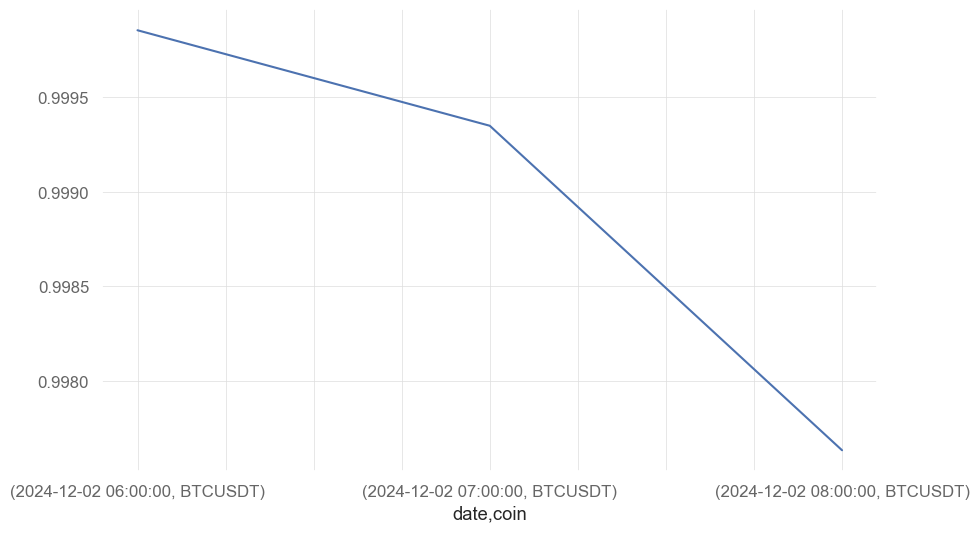

In [58]:
mr_strat_1.results.cstrategy.plot()

In [ ]:
#Run the WFO for each strategy (but the cash strategy)
for key, value in strategy_map.items():
    if key != 'cash_strat':
        print(key)

In [ ]:
#Run the WFO for each strategy (but the cash strategy)
for key, value in strategy_map.items():
    if key != 'cash_strat':
        value.test()

In [ ]:
#Make a new dictionary that contains the results strategy returns of the WFO
results_strategy_returns = {}
for key, value in strategy_map.items():
    if key != 'cash_strat':
        results_strategy_returns[key] = value.results.strategy
    elif key == 'cash_strat':
        results_strategy_returns[key] = value.strategy

In [73]:
portfolio_management = Portfolio_Management(results_strategy_returns)

In [74]:
keys_for_selected_strategy = portfolio_management.filter_by_correlation(low_corr_threshold=1).columns

In [75]:
selected_strategy = {key: value for key, value in strategy_map.items() if key in keys_for_selected_strategy}

Putting All together

In [29]:
def run_wfo_and_get_results_returns(strategy_map):
    """_summary_
    Takes the strategy map, runs the WFO for each strategy and returns the results of the strategy returns after the WFO.
    It also adds the df of the strategy returns to a csv file

    Args:
        strategy_map (_type_): _description_

    Returns:
        results_strategy_returns (_type_): _description_ the results of the strategy returns after the WFO
    """
    #Run the WFO for each strategy (but the cash strategy)
    for key, value in strategy_map.items():
        if key != 'cash_strat':
            value.test()
            
    #Make a new dictionary that contains the results strategy returns of the WFO
    results_strategy_returns = {}
    for key, value in strategy_map.items():
        if key != 'cash_strat':
            results_strategy_returns[key] = value.results.strategy
        elif key == 'cash_strat':
            results_strategy_returns[key] = value.strategy
            
    #Get the strategy returns df
    strategy_returns_df = pd.concat(results_strategy_returns, axis = 1).fillna(0)
    strategy_returns_df.to_csv('strategy_returns.csv')
    
    return results_strategy_returns

In [30]:
def perform_portfolio_management(strategy_map, low_corr_threshold = 1):
    """_summary_

    Args:
        strategy_map (_type_): _description_
        low_corr_threshold (int, optional): _description_. Defaults to 1.
    """
    results_strategy_returns = run_wfo_and_get_results_returns(strategy_map)

    portfolio_management = Portfolio_Management(results_strategy_returns)

    keys_for_selected_strategy = portfolio_management.filter_by_correlation(low_corr_threshold=low_corr_threshold).columns

    selected_strategy = {key: value for key, value in strategy_map.items() if key in keys_for_selected_strategy}

    return selected_strategy

In [31]:
perform_portfolio_management(strategy_map)

Train: 2024-09-30 01:00:00 - 2024-10-18 08:00:00
Test: 2024-10-18 09:00:00 - 2024-10-26 16:00:00
length of data: 880
Train: 2024-10-18 09:00:00 - 2024-11-05 16:00:00
Test: 2024-11-05 17:00:00 - 2024-11-14 00:00:00
Train: 2024-11-05 17:00:00 - 2024-11-24 00:00:00
Test: 2024-11-24 01:00:00 - 2024-12-02 08:00:00
length of data: 880
length of data: 880
Train: 2024-11-24 01:00:00 - 2024-12-12 08:00:00
Test: 2024-12-12 09:00:00 - 2024-12-20 16:00:00
length of data: 880
Train: 2024-12-12 09:00:00 - 2024-12-30 16:00:00
Test: 2024-12-30 17:00:00 - 2025-01-08 00:00:00
length of data: 880
Signal Generated
Signal Generated
Signal Generated
Signal Generated
Signal Generated
Position Initialized
Position Initialized
Position Initialized
Position Initialized
Position Initialized
Stop Loss Applied
Stop Loss Applied
Stop Loss Applied
Stop Loss Applied
Stop Loss Applied
Take Profit Applied
Take Profit Applied
Take Profit Applied
Take Profit Applied
Take Profit Applied
Partial Take Profit Applied
Positio

{'cash_strat':                              strategy  portfolio_value
 date                coin                              
 2024-09-30 01:00:00 BTCUSDT       0.0              1.0
                     ETHUSDT       0.0              1.0
 2024-09-30 02:00:00 BTCUSDT       0.0              1.0
                     ETHUSDT       0.0              1.0
 2024-09-30 03:00:00 BTCUSDT       0.0              1.0
 ...                               ...              ...
 2025-01-15 03:00:00 ETHUSDT       0.0              1.0
 2025-01-15 04:00:00 BTCUSDT       0.0              1.0
                     ETHUSDT       0.0              1.0
 2025-01-15 05:00:00 BTCUSDT       0.0              1.0
                     ETHUSDT       0.0              1.0
 
 [5146 rows x 2 columns],
 'mr_strat_1': <last_days_low.Last_Days_Low at 0x20f9b995670>}

### Strategy Optimization

In [12]:
counter_opt = 0
counter_reb = 0 

In [ ]:
#Run the optimization to get the strategy parameters
for key, value in strategy_map.items():
    if key != 'cash_strat':
        value.optimize()

In [12]:
#Storing the best_params for each strategy in a separate dictionary
best_params = {key: value.best_params for key, value in strategy_map.items() if key != 'cash_strat'}

In [ ]:
best_params

Putting all together

In [ ]:
counter_opt = 0
counter_reb = 0 

In [32]:
def perform_optimization(strategy_map):
    """_summary_

    Args:
        strategy_map (_type_): _description_
    """

    #Run the optimization to get the strategy parameters
    for key, value in strategy_map.items():
        if key != 'cash_strat':
            value.optimize()

    #Storing the best_params for each strategy in a separate dictionary
    best_params = {key: value.best_params for key, value in strategy_map.items() if key != 'cash_strat'}

    return best_params

In [33]:
perform_optimization(strategy_map)

length of data: 440
Signal Generated
Position Initialized
Stop Loss Applied
Take Profit Applied
Partial Take Profit Applied
Position Calculated
Manage Trade Applied
All Updated
Costs Applied
Data Downsampled
Coarse Analysis Done
Fine Analysis Done
Universe Updated
In Universe
In-sample performance: 0
length of data: 440
Signal Generated
Position Initialized
Stop Loss Applied
Take Profit Applied
Partial Take Profit Applied
Position Calculated
Manage Trade Applied
All Updated
Costs Applied
Data Downsampled
Coarse Analysis Done
Fine Analysis Done
Universe Updated
In Universe
In-sample performance: 0
length of data: 440
Signal Generated
Position Initialized
Stop Loss Applied
Take Profit Applied
Partial Take Profit Applied
Position Calculated
Manage Trade Applied
All Updated
Costs Applied
Data Downsampled
Coarse Analysis Done
Fine Analysis Done
Universe Updated
In Universe
In-sample performance: 0
length of data: 440
Signal Generated
Position Initialized
Stop Loss Applied
Take Profit Applie

{'mr_strat_1': {'std_window': 25,
  'mean_window': 10,
  'ema_window': 79,
  'hourly_lookback': 3,
  'daily_lookback': 3,
  '_min_pos': 0.07498118686350219,
  '_max_pos': 0.45924889196586727,
  'sl_ind_length': 20,
  'sl_ind_mult': 1.1429006806487336,
  'tp_mult': 5,
  'ptp_mult': 1.0564115790271003,
  'ptp_exit_percent': 0.7497988950401424},
 'tf_strat_1': {'std_window': 19,
  'mean_window': 6,
  'ema_window': 85,
  'str_length': 25,
  'str_mult': 3,
  '_min_pos': 0.6949941493453458,
  '_max_pos': 0.727271995856421,
  'sl_ind_length': 20,
  'sl_ind_mult': 3.066997884824298,
  'tp_mult': 5,
  'ptp_mult': 1.9611720243493493,
  'ptp_exit_percent': 0.8600804638103364}}

### Portfolio Optimization

In [ ]:
#Run the WFO for each strategy (but the cash strategy)
for key, value in strategy_map.items():
    if key != 'cash_strat':
        value.test()

In [41]:
#Make a new dictionary that contains the results strategy returns of the WFO
results_strategy_returns = {}
for key, value in strategy_map.items():
    if key != 'cash_strat':
        results_strategy_returns[key] = value.results.strategy
    elif key == 'cash_strat':
        results_strategy_returns[key] = value.strategy

In [42]:
#Get the strategy returns df
strategy_returns_df = pd.concat(results_strategy_returns, axis = 1).fillna(0)

In [43]:
strategy_returns_df

cash_strat  mr_strat_1  tf_strat_1
date                                                           
2024-09-30 01:00:00 BTCUSDT         0.0         0.0         0.0
                    ETHUSDT         0.0         0.0         0.0
2024-09-30 02:00:00 BTCUSDT         0.0         0.0         0.0
                    ETHUSDT         0.0         0.0         0.0
2024-09-30 03:00:00 BTCUSDT         0.0         0.0         0.0
...                                 ...         ...         ...
2025-01-15 03:00:00 ETHUSDT         0.0         0.0         0.0
2025-01-15 04:00:00 BTCUSDT         0.0         0.0         0.0
                    ETHUSDT         0.0         0.0         0.0
2025-01-15 05:00:00 BTCUSDT         0.0         0.0         0.0
                    ETHUSDT         0.0         0.0         0.0

[5146 rows x 3 columns]

In [ ]:
if step_size + train_size + test_size > len(results_strategy_returns):
    raise ValueError("Invalid train, test, or step size.")

In [48]:
#Get portfolio optimization instance
portfolio_optimization_instance = Portfolio_Optimization(log_rets = results_strategy_returns, train_size = 200, test_size = 200, step_size = 200, objective = 'multiple')

ValueError: Invalid train, test, or step size.

In [ ]:
#Run the optimization
train_data = strategy_returns_df.iloc[-train_size:]
train_data

In [ ]:
best_weights = portfolio_optimization_instance.optimize_weights_minimize(train_data)
best_weights

Putting all together

In [34]:
def perform_portfolio_optimization(strategy_map, train_size = 1000, test_size = 1000, step_size = 1000):
    """_summary_

    Args:
        strategy_returns_df (_type_): _description_
        train_size (int, optional): _description_. Defaults to 1000.
        test_size (int, optional): _description_. Defaults to 1000.
        step_size (int, optional): _description_. Defaults to 1000.
    """
    results_strategy_returns = run_wfo_and_get_results_returns(strategy_map)
    
    #Get portfolio optimization instance
    portfolio_optimization_instance = Portfolio_Optimization(log_rets = results_strategy_returns, train_size = train_size, test_size = test_size, step_size = step_size, objective = 'multiple')

    #Run the optimization
    train_data = strategy_returns_df.iloc[-train_size:]
    best_weights = portfolio_optimization_instance.optimize_weights_minimize(train_data)

    return best_weights

In [35]:
perform_portfolio_optimization(strategy_map, train_size, test_size, step_size)

Train: 2024-09-30 01:00:00 - 2024-10-18 08:00:00
Test: 2024-10-18 09:00:00 - 2024-10-26 16:00:00
Train: 2024-10-18 09:00:00 - 2024-11-05 16:00:00
Test: 2024-11-05 17:00:00 - 2024-11-14 00:00:00
length of data: 880length of data: 880

Train: 2024-11-05 17:00:00 - 2024-11-24 00:00:00
Test: 2024-11-24 01:00:00 - 2024-12-02 08:00:00
length of data: 880
Train: 2024-11-24 01:00:00 - 2024-12-12 08:00:00
Test: 2024-12-12 09:00:00 - 2024-12-20 16:00:00
length of data: 880
Train: 2024-12-12 09:00:00 - 2024-12-30 16:00:00
Test: 2024-12-30 17:00:00 - 2025-01-08 00:00:00
length of data: 880
Signal Generated
Signal Generated
Signal Generated
Signal Generated
Signal Generated
Position Initialized
Position Initialized
Position Initialized
Position Initialized
Position Initialized
Stop Loss Applied
Stop Loss Applied
Stop Loss Applied
Stop Loss Applied
Stop Loss Applied
Take Profit Applied
Take Profit Applied
Take Profit Applied
Take Profit Applied
Take Profit Applied
Partial Take Profit Applied
Positio

ValueError: Invalid train, test, or step size.

### Portfolio Risk Management

In [38]:
#Get the current_total_balance
current_total_balance = get_portfolio_value(exchange)
current_total_balance

33.3

In [ ]:
#Store the max allocation for each strategy in a dictionary
max_allocation_map = {
    key: best_weights[i] * current_total_balance / strategy.max_universe
    for i, (key, strategy) in enumerate(selected_strategy.items())
    if i < len(best_weights) and best_weights[i] > 0 and key != 'cash_strat'
}

max_allocation_map

In [41]:
#Rebuild the strategy map, with the updated max_allocation for each strategy
for key, value in selected_strategy.items():
    if key != 'cash_strat':
        value.max_dollar_allocation = max_allocation_map[key]

In [ ]:
#Run each strategy on enough data points and get the total portfolio value
length_of_data_to_run_strategy = step_size #This is because we are going to be using the parameters that were optimized on the last step
    #And thus taking into account the data with the same parameters of a previoused optimized period would be incorrect because markets may have changed
data_to_run_strategy = data.iloc[-length_of_data_to_run_strategy:]

current_strategy_returns = {
    key: value.trading_strategy(data_to_run_strategy, best_params[key])
    for key, value in selected_strategy.items()
    if key != 'cash_strat'
}

In [ ]:
current_strategy_returns_df = pd.concat(current_strategy_returns, axis = 1).fillna(0)

In [ ]:
portfolio_returns = np.dot(best_weights, current_strategy_returns_df.T)

In [ ]:
portfolio_rm_instance = Portfolio_RM(portfolio_returns)

In [ ]:
drawdown_limit, in_drawdown = portfolio_rm_instance.drawdown_limit(-0.15)

In [ ]:
if in_drawdown.iloc[-1]:
    #Liquidate the portfolio
    symbols_to_liquidate = current_strategy_returns_df.index.get_level_values(1).unique()[-1]
    liquidate(symbols_to_liquidate, exchange)
    #return True

Putting all_together

In [ ]:
def perform_portfolio_rm(best_weights, exchange, drawdown_threshold = -0.15):
    """_summary_"""
    current_strategy_returns_df = pd.read_csv('strategy_returns.csv')

    portfolio_returns = np.dot(best_weights, current_strategy_returns_df.T)

    portfolio_rm_instance = Portfolio_RM(portfolio_returns)

    drawdown_limit, in_drawdown = portfolio_rm_instance.drawdown_limit(drawdown_threshold)

    if in_drawdown.iloc[-1]:
        #Liquidate the portfolio
        print(f'Liquidating the portfolio because in_drawdown in {in_drawdown.iloc[-1]}')
        symbols_to_liquidate = symbols_in_current_balance(exchange)
        liquidate(symbols_to_liquidate, exchange)
        return True
    else :
        print(f'Portfolio is not in drawdown because in drawdown is {in_drawdown.iloc[-1]}')
        return False

In [ ]:
perform_portfolio_rm(best_weights, exchange)

### Taking Positions

In [ ]:
#Get the current_total_balance
current_total_balance = get_portfolio_value(exchange)
current_total_balance

In [ ]:
#Store the max allocation for each strategy in a dictionary
max_allocation_map = {
    key: best_weights[i] * current_total_balance / strategy.max_universe
    for i, (key, strategy) in enumerate(selected_strategy.items())
    if i < len(best_weights) and best_weights[i] > 0 and key != 'cash_strat'
}

max_allocation_map

In [ ]:
#Rebuild the strategy map, with the updated max_allocation for each strategy
for key, value in selected_strategy.items():
    if key != 'cash_strat':
        value.max_dollar_allocation = max_allocation_map[key]

In [ ]:
timeframe = '1h'
latest = fetch_latest_data(all_symbols, timeframe).result()

In [ ]:
append_to_csv_with_limit(latest, 'market_data.csv').result()

In [ ]:
data = load_data_from_csv('market_data.csv')

In [3]:
#Run each strategy on enough data points and get the total portfolio value
length_of_data_to_run_strategy = 100 #This does not have to do with anything with test_size or train_size,
    #but it is better to be equal to the test_size because we want get the latest returns of the strategy with the latest best_params to get the current strategy returns

In [ ]:
data_to_run_strategy = data.iloc[-length_of_data_to_run_strategy:]

In [ ]:
current_strategy_results = {
    key: value.trading_strategy(data_to_run_strategy, best_params[key])
    for key, value in selected_strategy.items()
    if key != 'cash_strat'
}

In [ ]:
current_allocation_strategy_map = {
    key: value['current_allocation']
    for key, value in selected_strategy.items()
    if key != 'cash_strat'
}

In [ ]:
current_allocation_results_df = pd.concat(current_allocation_strategy_map, axis=1).fillna(0).sum(axis=1)

In [ ]:
current_allocation = get_last_row(current_allocation_results_df)

In [ ]:
current_universe = list(
    set(
        value.current_universe
        for value in selected_strategy.values()
        if key != 'cash_strat'
    )
)

In [ ]:
# This will be used to plot the current portfolio 
portfolio_returns = np.dot(best_weights, current_strategy_returns_df.T)
portfolio_cumulative_returns = portfolio_returns.cumsum().apply(np.exp)
portfolio_cumulative_returns.plot()

In [ ]:
symbols_in_current_balance = symbols_in_current_balance(exchange)

In [ ]:
# Find symbols in current balance but not in current universe
symbols_not_in_universe = [symbol for symbol in symbols_in_current_balance if symbol not in current_universe]

# Liquidate the symbols not in the current universe
liquidate(symbols_not_in_universe, exchange)

In [ ]:
def get_coin_balance(coin):
    try:
        balance = exchange.fetch_balance()
        coin_balance = balance['total'][coin]
        return coin_balance
    except Exception as e:
        print(f"Error fetching balance for {coin}: {e}")
        return None

In [ ]:
def get_coin_allocation(coin, current_allocation_latest_row):
    return current_allocation_latest_row.loc[(slice(None), coin), :][-1]

In [ ]:
for coin in current_universe:
    formatted_coin = coin.replace('USDT', '')
    coin_balance = get_coin_balance(formatted_coin)
    current_coin_allocation = get_coin_allocation(coin)
    
    to_add = current_coin_allocation - coin_balance
    
    if to_add > 0:
        print(f"Adding {to_add} {formatted_coin} to the portfolio...")
        buy(to_add, coin, exchange)
    elif to_add < 0:
        print(f"Selling {-to_add} {formatted_coin} from the portfolio...")
        sell(-to_add, coin, exchange)

Putting Everything Together

In [ ]:
def run_strategy(exchange, halal_symbols, selected_strategy, best_params, best_weights, timeframe = '1h'):
    #Get the current_total_balance
    current_total_balance = get_portfolio_value(exchange)

    #Store the max allocation for each strategy in a dictionary
    max_allocation_map = {
        key: best_weights[i] * current_total_balance / strategy.max_universe
        for i, (key, strategy) in enumerate(selected_strategy.items())
        if i < len(best_weights) and best_weights[i] > 0 and key != 'cash_strat'
    }

    #Rebuild the strategy map, with the updated max_allocation for each strategy
    for key, value in selected_strategy.items():
        if key != 'cash_strat':
            value.max_dollar_allocation = max_allocation_map[key]
            
    
    timeframe = timeframe
    latest = fetch_latest_data(halal_symbols, timeframe).result()
    append_to_csv_with_limit(latest, 'market_data.csv').result()
    data = load_data_from_csv('market_data.csv')
    
    
    #Run each strategy on enough data points and get the total portfolio value
    length_of_data_to_run_strategy = 100 #This does not have to do with anything with test_size or train_size,
        #but it is better to be equal to the test_size because we want get the latest returns of the strategy with the latest best_params to get the current strategy returns
    data_to_run_strategy = data.iloc[-length_of_data_to_run_strategy:]
    
    current_strategy_results = {
        key: value.trading_strategy(data_to_run_strategy, best_params[key])
        for key, value in selected_strategy.items()
        if key != 'cash_strat'
    }
    
    current_allocation_strategy_map = {
        key: value['current_allocation']
        for key, value in current_strategy_results.items()
        if key != 'cash_strat'
    }
    
    current_allocation_results_df = pd.concat(current_allocation_strategy_map, axis=1).fillna(0).sum(axis=1)
    
    current_allocation = get_last_row(current_allocation_results_df)
    
    current_universe = list(
        set(
            value.current_universe
            for value in selected_strategy.values()
            if key != 'cash_strat'
        )
    )

    symbols_in_current_balance = symbols_in_current_balance(exchange)
    # Find symbols in current balance but not in current universe
    symbols_not_in_universe = [symbol for symbol in symbols_in_current_balance if symbol not in current_universe]

    # Liquidate the symbols not in the current universe
    print(f"Liquidating {symbols_not_in_universe}...")
    liquidate(symbols_not_in_universe, exchange)
    print("Liquidation complete.")

    for coin in current_universe:
        formatted_coin = coin.replace('USDT', '')
        coin_balance = get_coin_balance(formatted_coin)
        current_coin_allocation = get_coin_allocation(coin, current_allocation)
        
        to_add = current_coin_allocation - coin_balance
        
        if to_add > 0:
            print(f"Adding {to_add} {formatted_coin} to the portfolio...")
            buy(to_add, coin, exchange)
        elif to_add < 0:
            print(f"Selling {-to_add} {formatted_coin} from the portfolio...")
            sell(-to_add, coin, exchange)
            
    # This will be used to plot the current portfolio 
    portfolio_returns = np.dot(best_weights, current_strategy_returns_df.T)
    portfolio_cumulative_returns = portfolio_returns.cumsum().apply(np.exp)
    portfolio_cumulative_returns.plot()

In [ ]:
run_strategy(exchange, symbols, selected_strategy, best_params, best_weights, timeframe = '1h')

---

### Loop

In [26]:
# OUTSIDE OF METHOD:
upload_complete_market_data(halal_symbols, data_size=(train_size + test_size) * 4)
strategy_data_filename = 'strategy_data.csv'
market_data_filename = 'market_data.csv'
data = load_data_from_csv(market_data_filename)
strat_1_instance = Last_Days_Low(data, objective='multiple', train_size=train_size, test_size=test_size, step_size=step_size)
strat_2_instance = Sprtrnd_Breakout(data, objective='multiple', train_size=train_size, test_size=test_size, step_size=step_size)

counter = 0
cash_df = pd.DataFrame(data={'strategy': np.zeros(data.shape[0]), 'portfolio_value': np.ones(data.shape[0])}, index=data.index)
strategy_map = {
    'cash_strat': cash_df,
    'strat_1': strat_1_instance,
    'strat_2': strat_2_instance
}
best_params = None
best_weights = None
exchange = ccxt.kraken({
    'apiKey': api_key,
    'secret': api_secret
})
# halal_symbols = get_halal_symbols()
halal_symbols = ['BTCUSD', 'ETHUSD', 'LTCUSD']
symbols_to_liquidate = None
selected_strategy = None
drawdown_threshold = -0.15
train_size = 440
test_size = 200
step_size = 200
low_corr_thresh = 1.0
max_rows_market_data = market_data_size = 2000
timeframe = '1h'

strategy_optimization_frequency = 24  # Every 24 hours
portfolio_optimization_frequency = 24  # Every 24 hours
portfolio_management_frequency = 24  # Every 24 hours

# BEFORE THE MAIN LOOP
upload_complete_market_data(halal_symbols, data_size=train_size + test_size)

# THE MAIN LOOP
while True:
    now = dt.datetime.now()
    next_hour = (now + dt.timedelta(minutes=1)).replace(second=0, microsecond=0)
    sleep_duration = (next_hour - now).total_seconds()
    time.sleep(sleep_duration)
    data = load_data_from_csv(market_data_filename)

    if counter % strategy_optimization_frequency == 0:
        best_params = perform_optimization(strategy_map)

    if counter % portfolio_optimization_frequency == 0:
        best_weights = perform_portfolio_optimization(strategy_map, train_size=train_size, test_size=test_size, step_size=step_size)

    if counter % portfolio_management_frequency == 0:
        selected_strategy = perform_portfolio_management(strategy_map, low_corr_threshold=low_corr_thresh)

    if perform_portfolio_rm(best_weights, exchange, drawdown_threshold=drawdown_threshold):
        continue

    run_strategy(exchange, halal_symbols, selected_strategy, best_params, best_weights, timeframe=timeframe)
    
    counter += 1

NameError: name 'upload_complete_market_data' is not defined